<a href="https://colab.research.google.com/github/shuuuuyu/114-1-Programing-Language/blob/main/hw_5_%E5%8D%88%E9%A4%90_%E8%81%9A%E6%9C%83%E6%B1%BA%E7%AD%96%E5%99%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##🍽️ 智慧美食推薦系統

一鍵搜尋附近美食,AI 幫你快速決策!

### ✨ 核心功能:
- 利用google map API智慧篩選:價位、距離、營業狀態
- 雙模式推薦:隨機探索 / 高分優先
- AI 決策建議:Gemini 生成 100 字比較摘要
- 自動記錄:推薦結果寫入 [Google Sheets](https://docs.google.com/spreadsheets/d/1S2uWzdO1vXGdjDWhPHeOn-GtA5TrNpcK0B4C4V1YQyE/edit?gid=1129755567#gid=1129755567)
- 互動地圖:Folium 視覺化店家位置

### 本文件架構
- 簡單說明
- 畫面截圖
- 主程式
- 一開始用來測試google map API的程式

### 畫面截圖

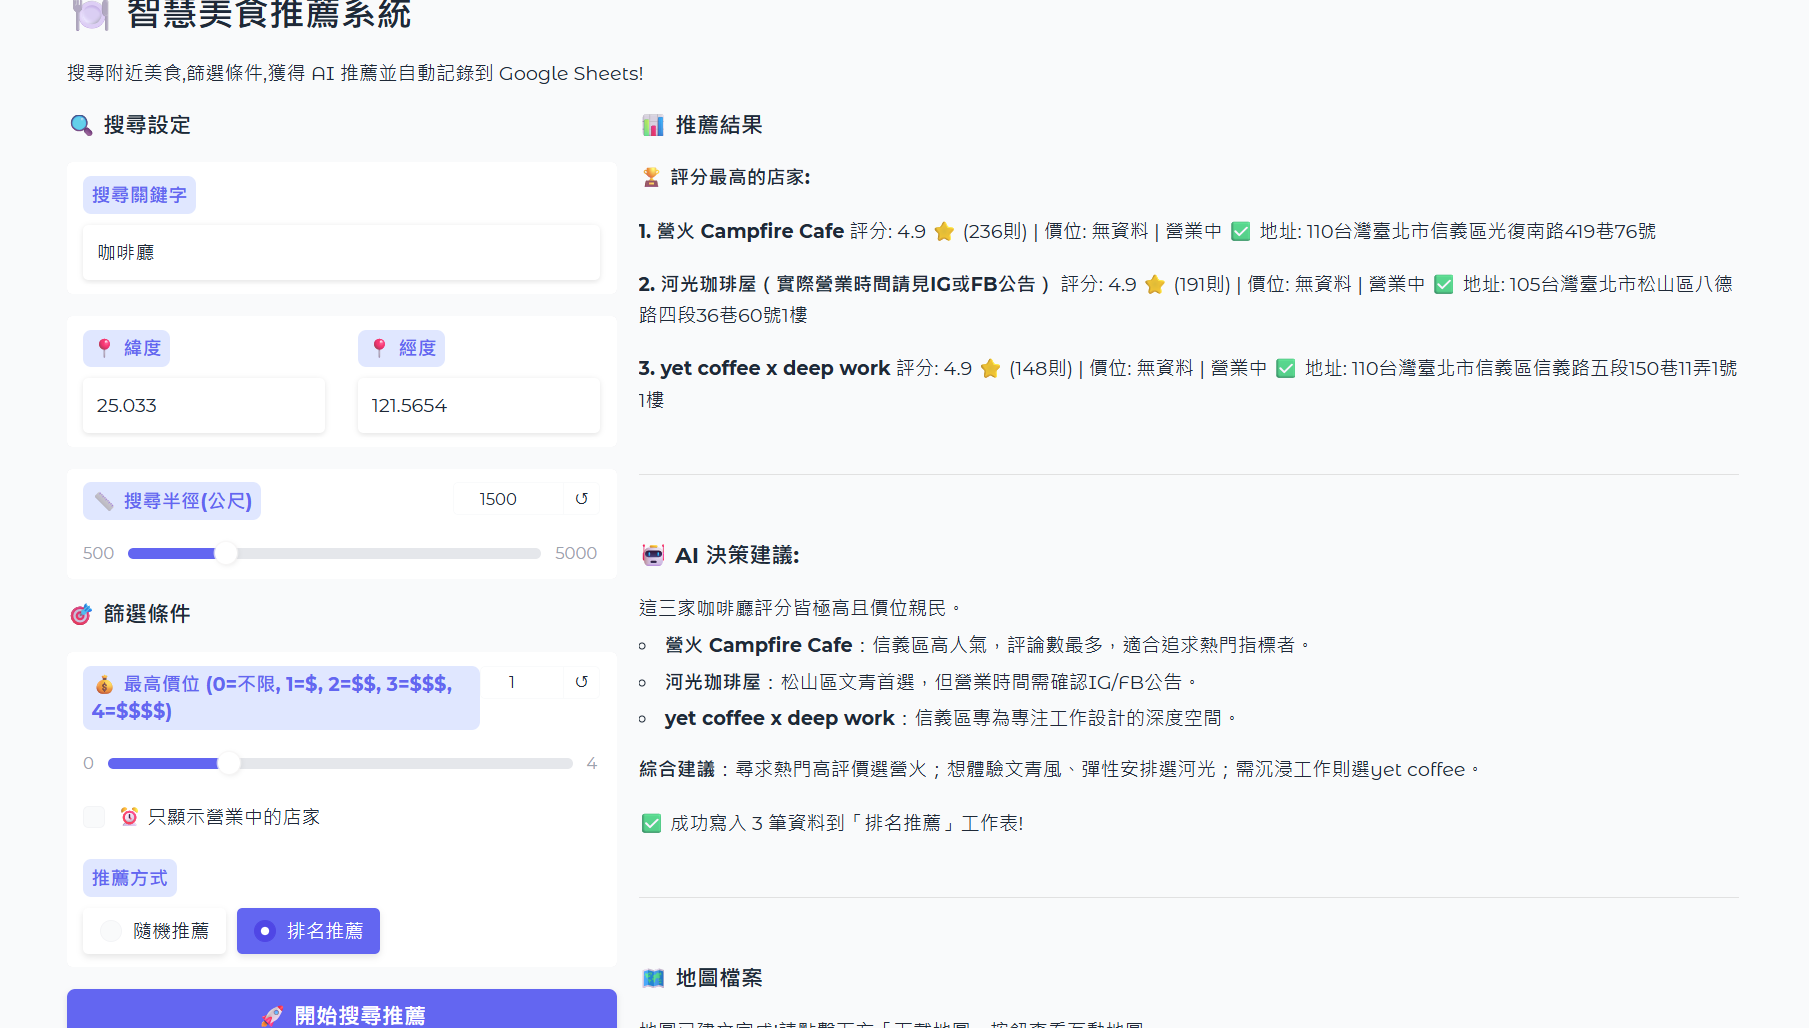

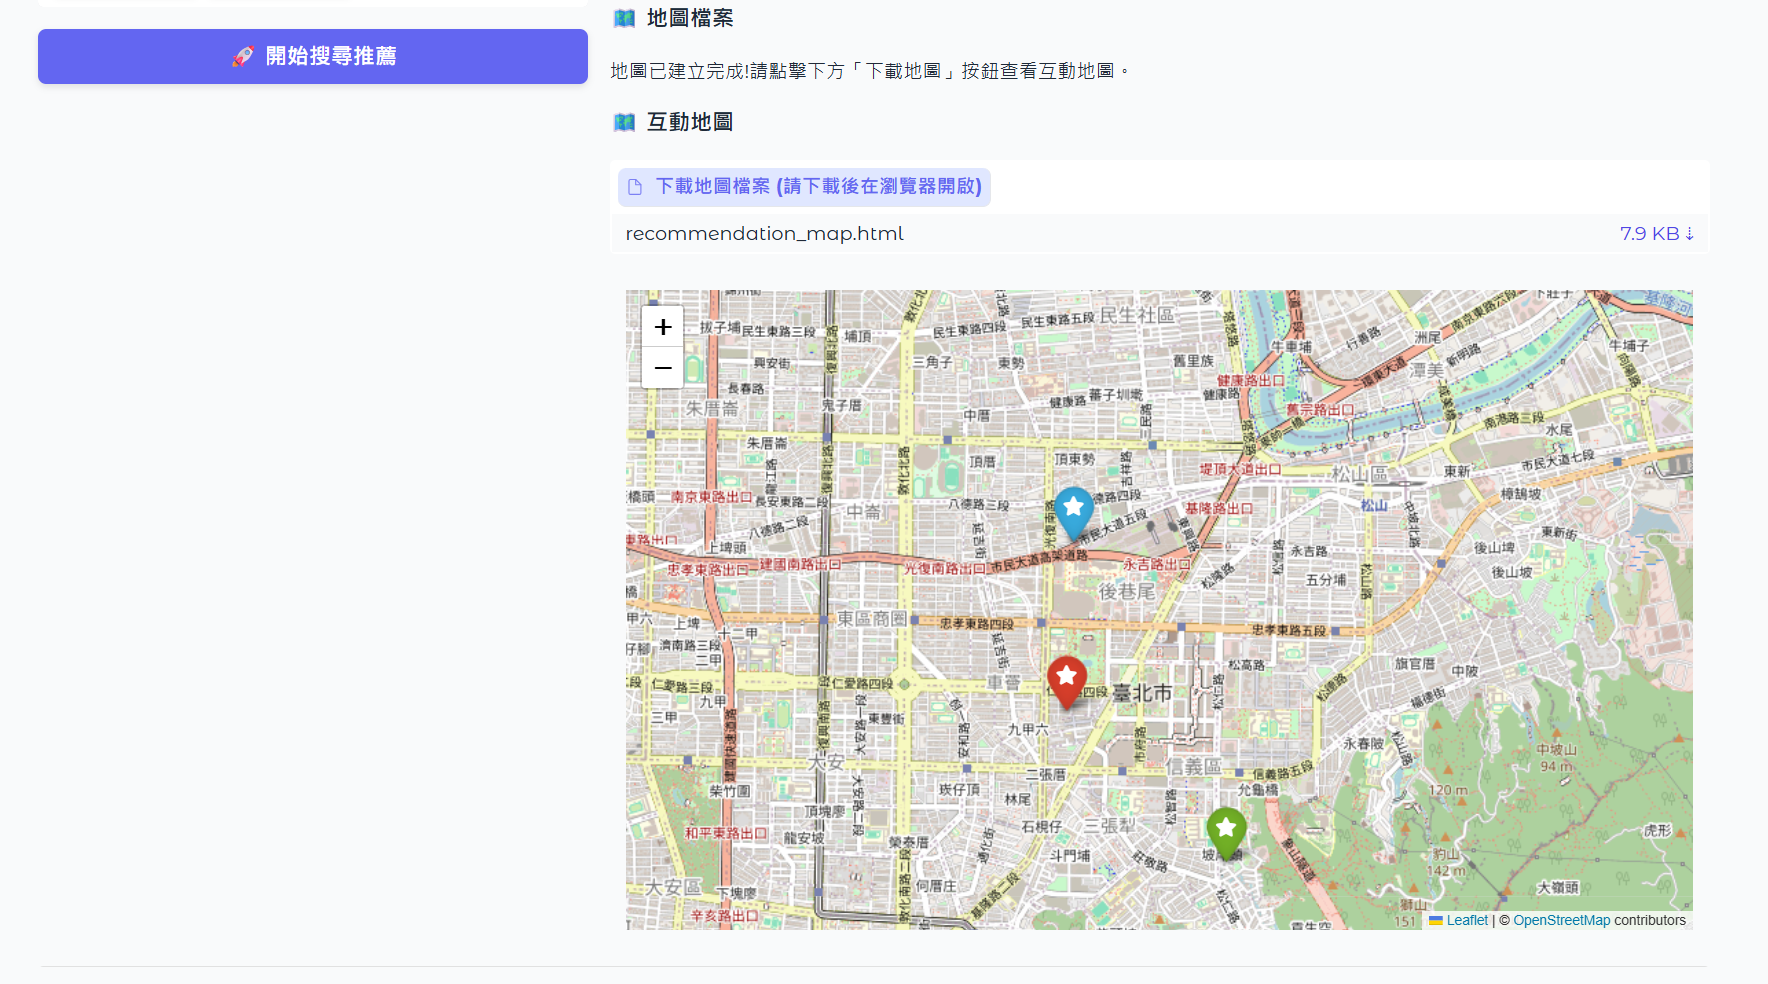

### 程式部分

In [4]:
# ==================== 步驟 1: 安裝和匯入套件 ====================
!pip install folium gradio gspread gspread-dataframe google-generativeai -q

import folium
import requests
from google.colab import userdata
import gradio as gr
import gspread
from google.auth import default
import pandas as pd
import random
import google.generativeai as genai
from datetime import datetime

print("✅ 套件安裝完成!")

✅ 套件安裝完成!


In [5]:
# ==================== 步驟 2: Google 授權 ====================
from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

print("✅ Google 授權完成!")

✅ Google 授權完成!


In [23]:
# ==================== 步驟 3: 設定 API 金鑰和常數 ====================
from google.colab import userdata
import google.generativeai as genai

# 從 Colab Secrets 取得 API 金鑰
API_KEY = userdata.get('API_KEY')
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

# 設定 Gemini
genai.configure(api_key=GEMINI_API_KEY)

# ✅ 使用正確的模型名稱
model = genai.GenerativeModel('models/gemini-2.5-flash')

# Google Sheets 連結
SHEET_URL = "https://docs.google.com/spreadsheets/d/1S2uWzdO1vXGdjDWhPHeOn-GtA5TrNpcK0B4C4V1YQyE/edit?usp=sharing"

print("✅ API 金鑰設定完成!")
print(f"Google API Key 前5碼: {API_KEY[:5]}...")
print(f"Gemini API Key 前5碼: {GEMINI_API_KEY[:5]}...")
print(f"✅ 使用模型: models/gemini-2.5-flash")

✅ API 金鑰設定完成!
Google API Key 前5碼: AIzaS...
Gemini API Key 前5碼: AIzaS...
✅ 使用模型: models/gemini-2.5-flash


In [31]:
# ==================== 步驟 4: 定義所有功能函數 ====================

def search_places(keyword, location_lat, location_lng, radius=2000):
    """搜尋附近的店家"""
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    params = {
        "location": f"{location_lat},{location_lng}",
        "radius": radius,
        "keyword": keyword,
        "language": "zh-TW",
        "key": API_KEY
    }

    response = requests.get(url, params=params)
    results = response.json()

    if results.get("status") != "OK":
        print(f"❌ 搜尋錯誤: {results.get('status')}")
        print(f"錯誤訊息: {results.get('error_message', '無')}")
        return []

    return results.get("results", [])

def get_place_details(place_id):
    """取得店家詳細資訊"""
    url = "https://maps.googleapis.com/maps/api/place/details/json"

    params = {
        "place_id": place_id,
        "fields": "name,rating,user_ratings_total,price_level,opening_hours,formatted_address,geometry,business_status",
        "language": "zh-TW",
        "key": API_KEY
    }

    response = requests.get(url, params=params)
    results = response.json()

    if results.get("status") == "OK":
        return results.get("result", {})
    return {}

def filter_places_optimized(places, max_price=None, only_open=False):
    """優化版:先用基本資訊篩選,減少 API 呼叫"""
    filtered = []

    for place in places:
        # 先用搜尋結果中已有的資訊篩選

        # 篩選價位(搜尋結果中已有 price_level)
        if max_price is not None and max_price > 0:
            price = place.get('price_level', 0)
            if price > max_price:
                continue

        # 篩選是否營業(搜尋結果中已有 opening_hours)
        if only_open:
            opening_hours = place.get('opening_hours', {})
            if not opening_hours.get('open_now', False):
                continue

        # ✅ 暫時不呼叫 details,只用基本資訊
        filtered.append(place)

    return filtered

def enrich_place_details(places):
    """只對選中的店家取得詳細資訊"""
    enriched = []
    for place in places:
        details = get_place_details(place['place_id'])
        if details:
            enriched.append({**place, **details})
        else:
            enriched.append(place)
    return enriched




def generate_summary_with_gemini(places_data):
    """使用 Gemini 生成三家店的比較摘要"""

    places_info = ""
    for idx, place in enumerate(places_data, 1):
        places_info += f"\n{idx}. {place['name']}\n"
        places_info += f"   評分: {place.get('rating', '無')} ({place.get('user_ratings_total', 0)}則)\n"
        places_info += f"   價位: {'$' * place.get('price_level', 1)}\n"
        places_info += f"   地址: {place.get('formatted_address', '無')}\n"

    prompt = f"""
以下是三家店家的資訊:
{places_info}

請用繁體中文,在100字以內,簡潔地比較這三家店的優缺點,幫助使用者快速決策。
格式要求:
- 每家店用一句話說明特色
- 最後給一個綜合建議
- 總字數不超過100字
"""

    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"Gemini 生成失敗: {str(e)}"

def write_to_sheet(places_data, recommendation_type, summary):
    """寫入 Google Sheets"""
    try:
        gsheets = gc.open_by_url(SHEET_URL)

        # 根據推薦類型選擇工作表
        worksheet_name = "隨機推薦" if recommendation_type == "隨機推薦" else "排名推薦"

        # 取得或建立工作表
        try:
            worksheet = gsheets.worksheet(worksheet_name)
        except:
            worksheet = gsheets.add_worksheet(title=worksheet_name, rows=100, cols=20)
            # 設定標題列
            headers = ["推薦時間", "店名", "評分", "評論數", "價位", "是否營業", "營業時間", "地址", "緯度", "經度", "AI決策建議"]
            worksheet.update('A1:K1', [headers])

        # 準備資料
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        rows_to_add = []
        for idx, place in enumerate(places_data):
            # 價位符號
            price_level = place.get('price_level', 0)
            price_str = '$' * price_level if price_level > 0 else '無資料'

            # 是否營業
            opening_hours = place.get('opening_hours', {})
            is_open = "營業中" if opening_hours.get('open_now', False) else "休息中"

            # 營業時間
            weekday_text = opening_hours.get('weekday_text', [])
            hours_str = '; '.join(weekday_text) if weekday_text else '無資料'

            # ✅ AI 摘要在每一列都寫入(合併儲存格的效果)
            row = [
                timestamp,
                place.get('name', ''),
                place.get('rating', ''),
                place.get('user_ratings_total', ''),
                price_str,
                is_open,
                hours_str,
                place.get('formatted_address', ''),
                place['geometry']['location']['lat'],
                place['geometry']['location']['lng'],
                summary  # ✅ 每列都寫入 AI 摘要
            ]
            rows_to_add.append(row)

        # 寫入資料
        worksheet.append_rows(rows_to_add)

        return f"✅ 成功寫入 {len(rows_to_add)} 筆資料到「{worksheet_name}」工作表!"

    except Exception as e:
        return f"❌ 寫入失敗: {str(e)}"

def create_map_with_recommendations(places_data):
    """建立地圖並標記推薦店家"""
    if not places_data:
        return None

    # 以第一家店為中心
    center_lat = places_data[0]['geometry']['location']['lat']
    center_lng = places_data[0]['geometry']['location']['lng']

    m = folium.Map(location=(center_lat, center_lng), zoom_start=15)

    colors = ['red', 'blue', 'green']

    for idx, place in enumerate(places_data):
        lat = place['geometry']['location']['lat']
        lng = place['geometry']['location']['lng']
        name = place['name']
        rating = place.get('rating', '無')
        user_ratings = place.get('user_ratings_total', 0)
        address = place.get('formatted_address', '')
        price = '$' * place.get('price_level', 1)

        opening_hours = place.get('opening_hours', {})
        is_open = "營業中 ✅" if opening_hours.get('open_now', False) else "休息中 ⛔"

        popup_html = f"""
        <b>推薦 {idx+1}: {name}</b><br>
        評分: {rating} ⭐ ({user_ratings}則)<br>
        價位: {price}<br>
        狀態: {is_open}<br>
        地址: {address}
        """

        folium.Marker(
            location=[lat, lng],
            tooltip=f"推薦{idx+1}: {name}",
            popup=folium.Popup(popup_html, max_width=300),
            icon=folium.Icon(color=colors[idx], icon='star', prefix='fa')
        ).add_to(m)

    return m

def search_and_recommend(keyword, latitude, longitude, radius, max_price, only_open, recommendation_type):
    """優化版主函數 - 減少 API 呼叫次數"""

    try:
        # 1. 搜尋店家 (1次 API)
        print(f"🔍 正在搜尋: {keyword}")
        places = search_places(keyword, latitude, longitude, int(radius))

        if not places:
            return "❌ 沒有找到任何結果", None, None

        print(f"找到 {len(places)} 個結果")

        # 2. ✅ 用基本資訊篩選(不呼叫 API)
        print(f"📊 正在篩選...")
        filtered_places = filter_places_optimized(
            places,
            max_price=int(max_price) if max_price > 0 else None,
            only_open=only_open
        )

        if not filtered_places:
            return "❌ 篩選後沒有符合條件的店家", None, None

        print(f"篩選後剩餘 {len(filtered_places)} 家店")

        # 3. 選擇推薦方式(不呼叫 API)
        if recommendation_type == "隨機推薦":
            selected_places = random.sample(filtered_places, min(3, len(filtered_places)))
            result_text = "🎲 **隨機推薦以下店家:**\n\n"
        else:
            sorted_places = sorted(filtered_places, key=lambda x: x.get('rating', 0), reverse=True)
            selected_places = sorted_places[:3]
            result_text = "🏆 **評分最高的店家:**\n\n"

        # 4. ✅ 只對選中的3家店取得詳細資訊 (僅3次 API!)
        print(f"📞 正在取得 {len(selected_places)} 家店的詳細資訊...")
        selected_places = enrich_place_details(selected_places)

        # 5. 顯示結果
        for idx, place in enumerate(selected_places, 1):
            name = place.get('name', '未知')
            rating = place.get('rating', '無')
            user_ratings = place.get('user_ratings_total', 0)
            price_level = place.get('price_level', 0)
            price = '$' * price_level if price_level > 0 else '無資料'
            opening_hours = place.get('opening_hours', {})
            is_open = "營業中 ✅" if opening_hours.get('open_now', False) else "休息中 ⛔"
            address = place.get('formatted_address', '')

            result_text += f"**{idx}. {name}**\n"
            result_text += f"   評分: {rating} ⭐ ({user_ratings}則) | 價位: {price} | {is_open}\n"
            result_text += f"   地址: {address}\n\n"

        # 6. Gemini 生成摘要 (1次 API)
        print("🤖 正在使用 Gemini 生成比較摘要...")
        summary = generate_summary_with_gemini(selected_places)
        result_text += f"\n---\n### 🤖 AI 決策建議:\n{summary}\n"

        # 7. 寫入 Google Sheets
        print("📝 正在寫入 Google Sheets...")
        write_result = write_to_sheet(selected_places, recommendation_type, summary)
        result_text += f"\n{write_result}"

        # 8. ✅ 建立地圖並儲存
        print("🗺️ 正在建立地圖...")
        map_obj = create_map_with_recommendations(selected_places)
        map_file_path = '/content/recommendation_map.html'
        map_obj.save(map_file_path)

        # ✅ 同時產生一個可以在 Colab 中直接查看的地圖
        print("✅ 全部完成!")
        print(f"📊 API 使用統計: Nearby Search(1次) + Place Details(3次) + Gemini(1次) = 總共5次")

        # 提示使用者可以下載地圖
        result_text += f"\n\n---\n### 🗺️ 地圖檔案\n地圖已建立完成!請點擊下方「下載地圖」按鈕查看互動地圖。"

        # ✅ 返回三個值:結果文字、地圖檔案路徑、地圖物件(用於直接顯示)
        return result_text, map_file_path, map_obj._repr_html_()

    except Exception as e:
        error_msg = f"❌ 發生錯誤: {str(e)}"
        print(error_msg)
        import traceback
        traceback.print_exc()
        return error_msg, None, None


print("✅ 所有函數定義完成!")

✅ 所有函數定義完成!


In [32]:
# ==================== 步驟 5: 建立 Gradio 介面 ====================

with gr.Blocks(title="美食推薦系統", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🍽️ 智慧美食推薦系統")
    gr.Markdown("搜尋附近美食,篩選條件,獲得 AI 推薦並自動記錄到 Google Sheets!")

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### 🔍 搜尋設定")
            keyword_input = gr.Textbox(
                label="搜尋關鍵字",
                value="咖啡廳",
                placeholder="例如: 拉麵、火鍋、咖啡廳"
            )

            with gr.Row():
                lat_input = gr.Number(label="📍 緯度", value=25.0330)
                lng_input = gr.Number(label="📍 經度", value=121.5654)

            radius_input = gr.Slider(
                label="📏 搜尋半徑(公尺)",
                minimum=500,
                maximum=5000,
                value=1500,
                step=100
            )

            gr.Markdown("### 🎯 篩選條件")
            price_input = gr.Slider(
                label="💰 最高價位 (0=不限, 1=$, 2=$$, 3=$$$, 4=$$$$)",
                minimum=0,
                maximum=4,
                value=0,
                step=1
            )

            open_checkbox = gr.Checkbox(
                label="⏰ 只顯示營業中的店家",
                value=False
            )

            recommendation_type = gr.Radio(
                label="推薦方式",
                choices=["隨機推薦", "排名推薦"],
                value="排名推薦"
            )

            submit_btn = gr.Button("🚀 開始搜尋推薦", variant="primary", size="lg")

        with gr.Column(scale=2):
            gr.Markdown("### 📊 推薦結果")
            result_output = gr.Markdown()

            gr.Markdown("### 🗺️ 互動地圖")
            # ✅ 改用檔案下載方式
            map_file_output = gr.File(label="下載地圖檔案 (請下載後在瀏覽器開啟)")
            # ✅ 同時保留 HTML 顯示(可能在某些環境有用)
            map_html_output = gr.HTML(label="地圖預覽")

    # ✅ 修改輸出對應
    submit_btn.click(
        fn=search_and_recommend,
        inputs=[
            keyword_input,
            lat_input,
            lng_input,
            radius_input,
            price_input,
            open_checkbox,
            recommendation_type
        ],
        outputs=[result_output, map_file_output, map_html_output]
    )

    gr.Markdown("""
    ---
    ### 💡 使用說明:
    1. 輸入搜尋關鍵字和位置
    2. 設定篩選條件(價位、是否營業)
    3. 選擇推薦方式(隨機 or 排名)
    4. 點擊「開始搜尋推薦」
    5. **點擊「下載地圖檔案」按鈕下載 HTML 地圖**
    6. 在瀏覽器中開啟下載的 HTML 檔案即可查看互動地圖!

    📝 資料會自動寫入: [Google Sheets](https://docs.google.com/spreadsheets/d/1S2uWzdO1vXGdjDWhPHeOn-GtA5TrNpcK0B4C4V1YQyE/edit?usp=sharing)

    🗺️ 地圖會以 HTML 檔案形式提供下載,下載後直接在瀏覽器開啟即可看到完整的互動地圖!
    """)

print("✅ Gradio 介面建立完成!")

✅ Gradio 介面建立完成!


In [33]:
# ==================== 步驟 6: 啟動 Gradio 介面 ====================
# ⚠️ 這個 cell 執行後會持續運行,不要中斷!

demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bd6f09b560920529d3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🔍 正在搜尋: 咖啡廳
找到 20 個結果
📊 正在篩選...
篩選後剩餘 13 家店
📞 正在取得 3 家店的詳細資訊...
🤖 正在使用 Gemini 生成比較摘要...
📝 正在寫入 Google Sheets...
🗺️ 正在建立地圖...
✅ 全部完成!
📊 API 使用統計: Nearby Search(1次) + Place Details(3次) + Gemini(1次) = 總共5次
🔍 正在搜尋: 咖啡廳
找到 20 個結果
📊 正在篩選...
篩選後剩餘 20 家店
📞 正在取得 3 家店的詳細資訊...
🤖 正在使用 Gemini 生成比較摘要...
📝 正在寫入 Google Sheets...
🗺️ 正在建立地圖...
✅ 全部完成!
📊 API 使用統計: Nearby Search(1次) + Place Details(3次) + Gemini(1次) = 總共5次
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://bd6f09b560920529d3.gradio.live


### 測試一

In [3]:
import folium
import requests
from google.colab import userdata
import gradio as gr

# 從 Colab Secrets 取得 API 金鑰
API_KEY = userdata.get('API_KEY')

def search_places(keyword, location_lat, location_lng, radius=2000):
    """搜尋附近的店家"""
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    params = {
        "location": f"{location_lat},{location_lng}",
        "radius": radius,
        "keyword": keyword,
        "language": "zh-TW",
        "key": API_KEY
    }

    response = requests.get(url, params=params)
    results = response.json()

    # 檢查是否有錯誤
    if results.get("status") != "OK":
        print(f"錯誤狀態: {results.get('status')}")
        print(f"錯誤訊息: {results.get('error_message', '無')}")
        return []

    return results.get("results", [])

def create_map(keyword, center_lat=25.0330, center_lng=121.5654, radius=2000, top_n=5):
    """
    建立地圖並標記店家
    keyword: 搜尋關鍵字
    center_lat, center_lng: 搜尋中心點
    radius: 搜尋半徑(公尺)
    top_n: 顯示前幾名
    """
    # 建立地圖
    m = folium.Map(location=(center_lat, center_lng), zoom_start=14)

    # 搜尋店家
    print(f"正在搜尋: {keyword}")
    places = search_places(keyword, center_lat, center_lng, radius)

    if not places:
        print("沒有找到任何結果!")
        return m

    print(f"找到 {len(places)} 個結果")

    # 取評分最高的前 N 個結果
    # 過濾掉沒有評分的店家
    rated_places = [p for p in places if 'rating' in p]
    top_places = sorted(rated_places, key=lambda x: x.get('rating', 0), reverse=True)[:top_n]

    print(f"\n前 {len(top_places)} 名高分店家:")

    # 在地圖上標記
    for idx, place in enumerate(top_places, 1):
        place_lat = place['geometry']['location']['lat']
        place_lng = place['geometry']['location']['lng']
        name = place['name']
        rating = place.get('rating', '無評分')
        user_ratings = place.get('user_ratings_total', 0)
        address = place.get('vicinity', '')

        print(f"{idx}. {name} - {rating}⭐ ({user_ratings}則)")

        # 設定標記顏色
        if rating >= 4.5:
            icon_color = 'green'
        elif rating >= 4.0:
            icon_color = 'blue'
        elif rating >= 3.5:
            icon_color = 'orange'
        else:
            icon_color = 'red'

        popup_html = f"""
        <b>第{idx}名: {name}</b><br>
        評分: {rating} ⭐ ({user_ratings}則評論)<br>
        地址: {address}
        """

        folium.Marker(
            location=[place_lat, place_lng],
            tooltip=f"{idx}. {name}",
            popup=folium.Popup(popup_html, max_width=300),
            icon=folium.Icon(color=icon_color, icon='info-sign')
        ).add_to(m)

    return m

# 方法1: 直接執行(不用輸入框)
keyword = "咖啡廳"  # 改成你想搜尋的關鍵字
m = create_map(keyword, center_lat=25.0330, center_lng=121.5654, radius=2000, top_n=5)
m

正在搜尋: 咖啡廳
找到 20 個結果

前 5 名高分店家:
1. 營火 Campfire Cafe - 4.9⭐ (236則)
2. 河光珈琲屋（實際營業時間請見IG或FB公告） - 4.9⭐ (191則)
3. yet coffee x deep work - 4.9⭐ (148則)
4. 安和咖啡商號 Cafe Ah! 信義安和咖啡/印度咖哩/美食/甜點 - 4.8⭐ (361則)
5. 鄰居 • Le Voisin ( 信義區插座WiFi 咖啡廳 / 永春 • 後山埤站必踩 平日不限時 咖啡館 / 永春三明治推薦 / 後山埤義大利麵推薦 / 台北信義區咖啡早午餐推薦 / 高 CP 值早午餐 餐廳 ) - 4.8⭐ (138則)
